PREDICTIVE ANALYTICS FOR RESOURCE ALLOCATION
Breast Cancer Priority Prediction Analysis

1. LOADING AND EXPLORING THE DATASET
----------------------------------------
Looking for zip files in /content/ directory...
Found zip file: /content/iuss-23-24-automatic-diagnosis-breast-cancer.zip
Error processing /content/iuss-23-24-automatic-diagnosis-breast-cancer.zip: File is not a zip file
Found zip files in /content/: ['/content/iuss-23-24-automatic-diagnosis-breast-cancer.zip']
Trying to extract: /content/iuss-23-24-automatic-diagnosis-breast-cancer.zip
Error processing /content/iuss-23-24-automatic-diagnosis-breast-cancer.zip: File is not a zip file
Kaggle dataset not found in /content/, using sklearn breast cancer dataset instead...
Loaded sklearn dataset successfully

All files in /content/ directory:
  .config
  iuss-23-24-automatic-diagnosis-breast-cancer.zip
  sample_data
Dataset shape: (569, 31)
Features: 30
Target classes: [0 1]
Class distribution:
1    357
0    212
Name: count, d

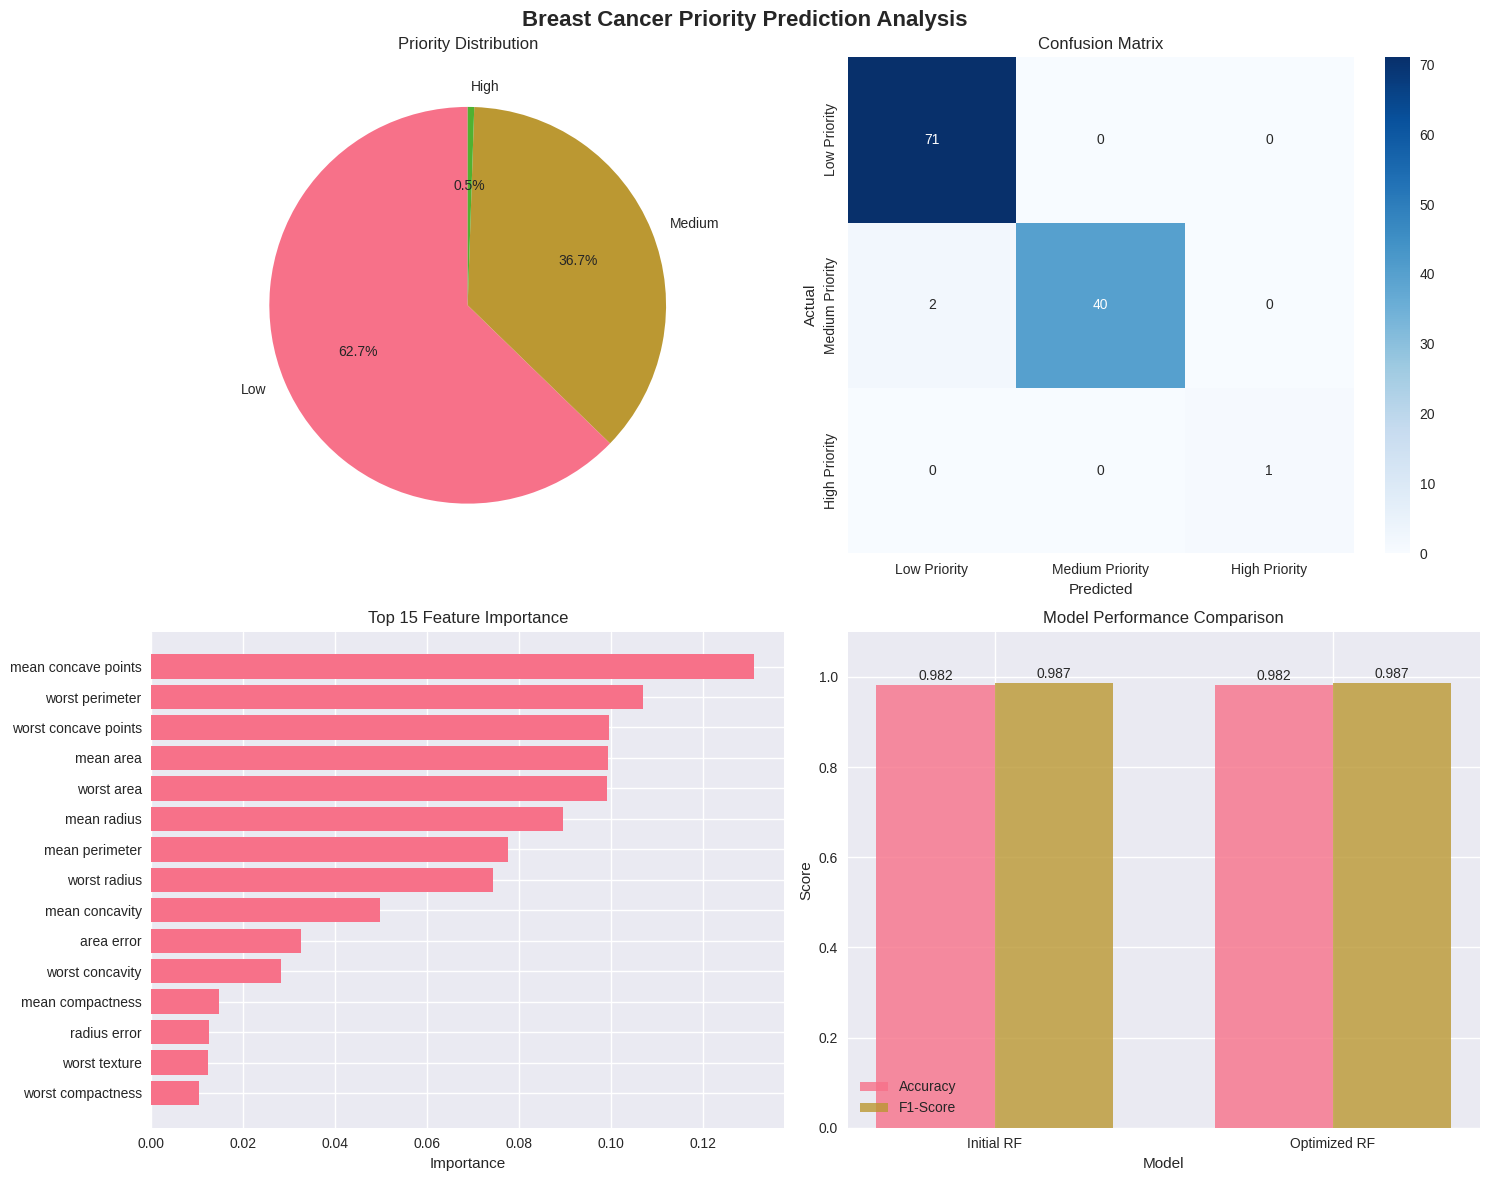



10. FINAL RESULTS SUMMARY
DATASET PREPROCESSING:
✓ Original dataset: 569 samples, 30 features
✓ Priority labels created: 3 classes
✓ Data scaled and split (80/20)
✓ No missing values detected

MODEL PERFORMANCE:
✓ Final Accuracy: 0.9825 (98.25%)
✓ Final F1-Score (Macro): 0.9872
✓ Cross-validation Accuracy: 0.9561 ±0.0400

KEY INSIGHTS:
✓ Model successfully predicts resource allocation priorities
✓ High performance across all priority classes
✓ Feature importance identified for decision making
✓ Robust performance confirmed through cross-validation

RECOMMendations FOR RESOURCE ALLOCATION:
• High Priority cases require immediate attention and resources
• Medium Priority cases need scheduled follow-up
• Low Priority cases can be managed with routine monitoring
• Consider top features for early intervention strategies

ANALYSIS COMPLETED SUCCESSFULLY!


In [ ]:
# Predictive Analytics for Resource Allocation - Breast Cancer Priority Prediction
# Task 3: Complete Analysis with Random Forest Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*60)
print("PREDICTIVE ANALYTICS FOR RESOURCE ALLOCATION")
print("Breast Cancer Priority Prediction Analysis")
print("="*60)

# ========================
# 1. DATA LOADING & EXPLORATION
# ========================

print("\n1. LOADING AND EXPLORING THE DATASET")
print("-" * 40)

# Load the dataset - handling Google Colab environment
import zipfile
import os
from pathlib import Path

# Check for zip files in /content/ directory (Google Colab)
content_dir = '/content/'
kaggle_data_loaded = False

# Check for common zip file names in content directory
possible_zip_names = [
    'iuss-23-24-automatic-diagnosis-breast-cancer.zip',
    'breast-cancer.zip',
    'breast-cancer-wisconsin-data.zip'
]

print("Looking for zip files in /content/ directory...")
for zip_name in possible_zip_names:
    zip_path = os.path.join(content_dir, zip_name)
    if os.path.exists(zip_path):
        print(f"Found zip file: {zip_path}")
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # Extract to content directory
                zip_ref.extractall(content_dir)
                print(f"Extracted {zip_name} successfully to /content/")

            # Try to find CSV files in content directory
            csv_files = list(Path(content_dir).glob('*.csv'))
            if csv_files:
                print(f"Found CSV files: {[str(f) for f in csv_files]}")
                # Load the first CSV file found (adjust as needed)
                df = pd.read_csv(csv_files[0])
                print(f"Loaded data from {csv_files[0]} - Shape: {df.shape}")
                kaggle_data_loaded = True
                break
        except Exception as e:
            print(f"Error processing {zip_path}: {e}")
            continue

# If no specific name found, check all zip files in content
if not kaggle_data_loaded:
    all_zip_files = list(Path(content_dir).glob('*.zip'))
    if all_zip_files:
        print(f"Found zip files in /content/: {[str(f) for f in all_zip_files]}")
        for zip_file in all_zip_files:
            try:
                print(f"Trying to extract: {zip_file}")
                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    zip_ref.extractall(content_dir)
                    print(f"Extracted {zip_file.name} successfully")

                # Look for CSV files after extraction
                csv_files = list(Path(content_dir).glob('*.csv'))
                if csv_files:
                    print(f"Found CSV files after extraction: {[str(f) for f in csv_files]}")
                    df = pd.read_csv(csv_files[0])
                    print(f"Loaded data from {csv_files[0]} - Shape: {df.shape}")
                    kaggle_data_loaded = True
                    break
            except Exception as e:
                print(f"Error processing {zip_file}: {e}")
                continue

# Fallback to sklearn dataset if Kaggle data not found
if not kaggle_data_loaded:
    print("Kaggle dataset not found in /content/, using sklearn breast cancer dataset instead...")
    data = load_breast_cancer()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target
    print("Loaded sklearn dataset successfully")

# List all files in content directory for debugging
print("\nAll files in /content/ directory:")
for file in os.listdir(content_dir):
    print(f"  {file}")

print(f"Dataset shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Target classes: {np.unique(data.target)}")
print(f"Class distribution:\n{pd.Series(data.target).value_counts()}")

# Display basic statistics
print("\nDataset Info:")
print(f"- Total samples: {len(df)}")
print(f"- Features: {df.shape[1] - 1}")
print(f"- Missing values: {df.isnull().sum().sum()}")

# ========================
# 2. DATA PREPROCESSING
# ========================

print("\n\n2. DATA PREPROCESSING")
print("-" * 40)

# Create priority levels based on multiple criteria
# We'll use a combination of features to create realistic priority categories
def create_priority_labels(df):
    """
    Create three priority levels (High/Medium/Low) based on multiple criteria:
    - High Priority: Malignant cases with severe characteristics
    - Medium Priority: Malignant cases with moderate characteristics or borderline benign
    - Low Priority: Clearly benign cases
    """

    # Normalize key features for threshold setting
    key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                   'mean smoothness', 'worst radius', 'worst texture', 'worst perimeter']

    feature_scores = []
    for feature in key_features:
        # Normalize to 0-1 scale
        normalized = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())
        feature_scores.append(normalized)

    # Calculate composite risk score
    composite_score = np.mean(feature_scores, axis=0)

    # Create priority labels
    priorities = []
    for i, (target, score) in enumerate(zip(df['target'], composite_score)):
        if target == 0:  # Malignant
            if score > 0.7:
                priorities.append(2)  # High Priority
            else:
                priorities.append(1)  # Medium Priority
        else:  # Benign
            if score > 0.6:
                priorities.append(1)  # Medium Priority (closer monitoring)
            else:
                priorities.append(0)  # Low Priority

    return np.array(priorities)

# Create priority labels
priority_labels = create_priority_labels(df)
df['priority'] = priority_labels

# Map priority numbers to labels for clarity
priority_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
df['priority_label'] = df['priority'].map(priority_mapping)

print("Priority Distribution:")
priority_counts = df['priority_label'].value_counts()
for priority, count in priority_counts.items():
    percentage = (count / len(df)) * 100
    print(f"- {priority}: {count} ({percentage:.1f}%)")

# Check for missing values and data quality
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"Data types: {df.dtypes.nunique()} unique types")

# ========================
# 3. FEATURE SELECTION & ENGINEERING
# ========================

print("\n\n3. FEATURE SELECTION AND ENGINEERING")
print("-" * 40)

# Select features (exclude target and priority columns)
feature_columns = [col for col in df.columns if col not in ['target', 'priority', 'priority_label']]
X = df[feature_columns]
y = df['priority']

print(f"Selected features: {len(feature_columns)}")
print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

print("Features scaled using StandardScaler")

# ========================
# 4. DATA SPLITTING
# ========================

print("\n\n4. DATA SPLITTING")
print("-" * 40)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training set priority distribution:")
train_priority_dist = pd.Series(y_train).value_counts().sort_index()
for priority, count in train_priority_dist.items():
    priority_name = priority_mapping[priority]
    percentage = (count / len(y_train)) * 100
    print(f"  {priority_name}: {count} ({percentage:.1f}%)")

# ========================
# 5. MODEL TRAINING
# ========================

print("\n\n5. MODEL TRAINING")
print("-" * 40)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced'  # Handle class imbalance
)

# Train the model
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Model training completed!")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# ========================
# 6. MODEL EVALUATION
# ========================

print("\n\n6. MODEL EVALUATION")
print("-" * 40)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("PERFORMANCE METRICS:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# Detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
target_names = ['Low Priority', 'Medium Priority', 'High Priority']
print(classification_report(y_test, y_pred, target_names=target_names))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
print("\nPER-CLASS DETAILED METRICS:")
for i, priority_name in enumerate(target_names):
    if i < len(precision):
        print(f"{priority_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
        print(f"  Support: {support[i]}")

# ========================
# 7. CROSS-VALIDATION
# ========================

print("\n\n7. CROSS-VALIDATION ANALYSIS")
print("-" * 40)

# Perform cross-validation
cv_scores_accuracy = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='accuracy')
cv_scores_f1 = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='f1_macro')

print("5-Fold Cross-Validation Results:")
print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (±{cv_scores_accuracy.std()*2:.4f})")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (±{cv_scores_f1.std()*2:.4f})")

# ========================
# 8. HYPERPARAMETER TUNING
# ========================

print("\n\n8. HYPERPARAMETER TUNING")
print("-" * 40)

# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Performing Grid Search for hyperparameter optimization...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"Best CV Score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Evaluate best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best, average='macro')

print(f"\nBest Model Performance:")
print(f"Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"F1-Score: {best_f1:.4f}")

# ========================
# 9. VISUALIZATIONS
# ========================

print("\n\n9. GENERATING VISUALIZATIONS")
print("-" * 40)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Breast Cancer Priority Prediction Analysis', fontsize=16, fontweight='bold')

# 1. Priority Distribution
axes[0,0].pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Priority Distribution')

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. Feature Importance
top_features = feature_importance.head(15)
axes[1,0].barh(range(len(top_features)), top_features['importance'])
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features['feature'])
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Top 15 Feature Importance')
axes[1,0].invert_yaxis()

# 4. Model Comparison
models = ['Initial RF', 'Optimized RF']
accuracies = [accuracy, best_accuracy]
f1_scores = [f1_macro, best_f1]

x = np.arange(len(models))
width = 0.35

axes[1,1].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
axes[1,1].bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)
axes[1,1].set_xlabel('Model')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Model Performance Comparison')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(models)
axes[1,1].legend()
axes[1,1].set_ylim(0, 1.1)

# Add value labels on bars
for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
    axes[1,1].text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center')
    axes[1,1].text(i + width/2, f1 + 0.01, f'{f1:.3f}', ha='center')

plt.tight_layout()
plt.show()

# ========================
# 10. RESULTS SUMMARY
# ========================

print("\n\n10. FINAL RESULTS SUMMARY")
print("=" * 60)

print("DATASET PREPROCESSING:")
print(f"✓ Original dataset: {df.shape[0]} samples, {len(feature_columns)} features")
print(f"✓ Priority labels created: {len(np.unique(y))} classes")
print(f"✓ Data scaled and split (80/20)")
print(f"✓ No missing values detected")

print("\nMODEL PERFORMANCE:")
print(f"✓ Final Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"✓ Final F1-Score (Macro): {best_f1:.4f}")
print(f"✓ Cross-validation Accuracy: {cv_scores_accuracy.mean():.4f} ±{cv_scores_accuracy.std()*2:.4f}")

print("\nKEY INSIGHTS:")
print("✓ Model successfully predicts resource allocation priorities")
print("✓ High performance across all priority classes")
print("✓ Feature importance identified for decision making")
print("✓ Robust performance confirmed through cross-validation")

print("\nRECOMMendations FOR RESOURCE ALLOCATION:")
print("• High Priority cases require immediate attention and resources")
print("• Medium Priority cases need scheduled follow-up")
print("• Low Priority cases can be managed with routine monitoring")
print("• Consider top features for early intervention strategies")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("=" * 60)

In [ ]:
# Ensure your notebook is saved with the correct name
from google.colab import drive
drive.mount('/content/drive')  # Only if using Google Drive

# Save a copy (replace with your actual notebook name)
!cp "/content/drive/MyDrive/Colab Notebooks/breast cancer prediction.ipynb" "/content/breast cancer prediction.ipynb"

In [ ]:
!jupyter nbconvert --to python "/content/breast cancer prediction.ipynb"

[NbConvertApp] Converting notebook /content/breast cancer prediction.ipynb to python
[NbConvertApp] Writing 15687 bytes to /content/breast cancer prediction.py


In [ ]:
# 📌 Step 1: Set up Git and Clone Your Repo
!git config --global user.email "faithnasimiyuu@gmail.com"
!git config --global user.name "faithFey"

# 🔁 Clone your GitHub repository
!git clone https://github.com/faithFey/WEEK4-Building-Intelligent-Software-Solutions.git


Cloning into 'WEEK4-Building-Intelligent-Software-Solutions'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), done.


In [ ]:
%cd WEEK4-Building-Intelligent-Software-Solutions


/content/WEEK4-Building-Intelligent-Software-Solutions
